## 4. Training and inference -->**Regression**

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import LinearRegression, MultiTaskLasso, MultiTaskElasticNet, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

import xgboost

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

import pandas_profiling
from pandas_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)

/home/egkiastas/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


## Read Data

In [2]:
LEAGUE_DATAPATH = '/.../data/all_players_league_match_info.csv'

league_data = pd.read_csv(LEAGUE_DATAPATH, parse_dates=['startTimestamp', 'player_birth', 'previous_date'])
league_data = league_data[['player_name','player_position','player_foot','player_height','age',\
    'fifa_rating','fifa_potential','after_injury','injury_days','rest_days','form_last1','form_last3','form_last5','form_last10',\
    'current_team_category','opponent_category','home_fixture',\
    'Performance']]
league_data

,player_name,player_position,player_foot,player_height,age,fifa_rating,fifa_potential,after_injury,injury_days,rest_days,form_last1,form_last3,form_last5,form_last10,current_team_category,opponent_category,home_fixture,Performance
0,Messi,F,Left,169,28.18,94,95,0,0,78.0,NaN,NaN,NaN,NaN,1,0,0,7.8
1,Messi,F,Left,169,28.20,94,95,0,0,6.0,8.60,NaN,NaN,NaN,1,0,1,9.4
2,Messi,F,Left,169,28.24,94,95,0,0,14.0,9.00,NaN,NaN,NaN,1,1,0,8.6
3,Messi,F,Left,169,28.26,94,95,0,0,4.0,9.30,8.950,NaN,NaN,1,0,1,10.0
4,Messi,F,Left,169,28.27,94,95,0,0,3.0,9.55,9.275,NaN,NaN,1,0,0,9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626,Azpilicueta,D,Right,178,32.41,83,83,0,0,3.0,7.05,7.175,7.066667,7.018182,1,1,0,7.2
5627,Azpilicueta,D,Right,178,32.41,83,83,0,0,3.0,7.20,7.175,7.066667,7.036364,1,0,0,7.2
5628,Azpilicueta,D,Right,178,32.43,83,83,0,0,5.0,7.30,7.175,7.216667,7.081818,1,1,1,7.4
5629,Azpilicueta,D,Right,178,32.55,83,83,1,7,16.0,6.95,7.075,7.100000,6.990909,1,0,0,6.5


In [3]:
league_data.isnull().any(axis = 1).sum()
# league_data
# league_data.iloc[220:240]
# league_data.dropna(how='any', inplace=True)
league_data['form_last1'] = league_data['form_last1'].fillna(league_data.groupby('player_name')['form_last1'].transform('mean'))
league_data['form_last3'] = league_data['form_last3'].fillna(league_data.groupby('player_name')['form_last3'].transform('mean'))
league_data['form_last5'] = league_data['form_last5'].fillna(league_data.groupby('player_name')['form_last5'].transform('mean'))
league_data['form_last10'] = league_data['form_last10'].fillna(league_data.groupby('player_name')['form_last10'].transform('mean'))
league_data.isnull().any(axis = 1).sum()
# league_data
# league_data.iloc[220:240]

300

0

### Fixed Effects Model on Player Name

In [4]:
league_data = pd.get_dummies(league_data, prefix=['player_position', 'player_foot'], columns=['player_position', 'player_foot'])
league_data.drop(labels=['player_name'], axis=1, inplace=True)
# league_data = pd.get_dummies(league_data, prefix=['player_name'], columns=['player_name'])
# league_data = pd.get_dummies(league_data, prefix=['injury_type'], columns=['injury_type'])
league_data

,player_height,age,fifa_rating,fifa_potential,after_injury,injury_days,rest_days,form_last1,form_last3,form_last5,form_last10,current_team_category,opponent_category,home_fixture,Performance,player_position_D,player_position_F,player_position_G,player_position_M,player_foot_Left,player_foot_Right
0,169,28.18,94,95,0,0,78.0,8.347098,8.346847,8.345455,8.349937,1,0,0,7.8,0,1,0,0,1,0
1,169,28.20,94,95,0,0,6.0,8.600000,8.346847,8.345455,8.349937,1,0,1,9.4,0,1,0,0,1,0
2,169,28.24,94,95,0,0,14.0,9.000000,8.346847,8.345455,8.349937,1,1,0,8.6,0,1,0,0,1,0
3,169,28.26,94,95,0,0,4.0,9.300000,8.950000,8.345455,8.349937,1,0,1,10.0,0,1,0,0,1,0
4,169,28.27,94,95,0,0,3.0,9.550000,9.275000,8.345455,8.349937,1,0,0,9.1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626,178,32.41,83,83,0,0,3.0,7.050000,7.175000,7.066667,7.018182,1,1,0,7.2,1,0,0,0,0,1
5627,178,32.41,83,83,0,0,3.0,7.200000,7.175000,7.066667,7.036364,1,0,0,7.2,1,0,0,0,0,1
5628,178,32.43,83,83,0,0,5.0,7.300000,7.175000,7.216667,7.081818,1,1,1,7.4,1,0,0,0,0,1
5629,178,32.55,83,83,1,7,16.0,6.950000,7.075000,7.100000,6.990909,1,0,0,6.5,1,0,0,0,0,1


## Begin

#### Helper functions

In [5]:
def get_metrics(y_test, y_pred):
    r2 = r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = mean_squared_error(y_test,y_pred, squared=False)
    mae = mean_absolute_error(y_test,y_pred)
    # correlation_energy, p_energy = spearmanr(y_test, y_pred)
    return r2, mse, rmse, mae

In [6]:
def print_metrics(r2, mse, rmse, mae):
    print(f'R2 score: {r2:.5f}')
    print(f'MSE: {mse:.5f}')
    print(f'RMSE: {rmse:.5f}')
    print(f'MAE: {mae:.5f}')
    # correlation_energy, p_energy = spearmanr(y_test, y_pred)
    # print(f'Correlation: {correlation_energy:.5f}\n' + f'pvalue: {p_energy:.5f}')

### Split

In [7]:
# Splitting the dataset into the training set and test set
# BIG
x_train, x_test, y_train, y_test = train_test_split(league_data.loc[:, league_data.columns != 'Performance'], league_data['Performance'], test_size=0.1, random_state=42)
x_train.shape
x_test.shape
y_train.shape
y_test.shape

feature_names = league_data.loc[:, league_data.columns != 'Performance'].columns.values

(5067, 20)

(564, 20)

(5067,)

(564,)

### Scaling

In [8]:
scaling_input = 1
if scaling_input:
    # print('Before scaling: ', x_train.mean())
    sc_x = StandardScaler()
    x_train = pd.DataFrame(sc_x.fit_transform(x_train), index=x_train.index, columns = x_train.columns)
    # print(sc.mean_)
    # print(sc.scale_)
    x_test = pd.DataFrame(sc_x.transform(x_test), index=x_test.index, columns = x_test.columns)
    # print('After scaling: ', x_train.mean())
    # print(sc.mean_)
    # print(sc.scale_)
else:
    pass

scaling_output = 0
if scaling_output:
    # print('Before scaling: ', y_test.mean())
    sc_y = StandardScaler()
    # y_train.values.reshape(-1,1).shape
    # y_test.values.reshape(-1,1).shape
    y_train = pd.DataFrame(y_train)
    y_train = pd.DataFrame(sc_y.fit_transform(y_train), index=y_train.index, columns = y_train.columns)
    # # print(sc.mean_)
    # # print(sc.scale_)
    y_test = pd.DataFrame(y_test)
    y_test = pd.DataFrame(sc_y.transform(y_test), index=y_test.index, columns = y_test.columns)
    # print('After scaling: ', y_test.mean())
    # print(sc.mean_)
    # print(sc.scale_)

### Linear Regression

In [9]:
linreg_model = LinearRegression().fit(x_train, y_train)
y_pred = linreg_model.predict(x_test)
if scaling_output==1:
    y_test_lr = sc_y.inverse_transform(y_test)
    y_pred_lr = sc_y.inverse_transform(y_pred.reshape(-1, 1))
else:
    y_test_lr = y_test
    y_pred_lr = y_pred

In [10]:
# Calculating R2 score, rmse and mae
linreg_r2_before, linreg_mse_before, linreg_rmse_before, linreg_mae_before = get_metrics(y_test_lr, y_pred_lr)
print_metrics(linreg_r2_before, linreg_mse_before, linreg_rmse_before, linreg_mae_before)

R2 score: 0.60297
MSE: 0.24908
RMSE: 0.49908
MAE: 0.38357


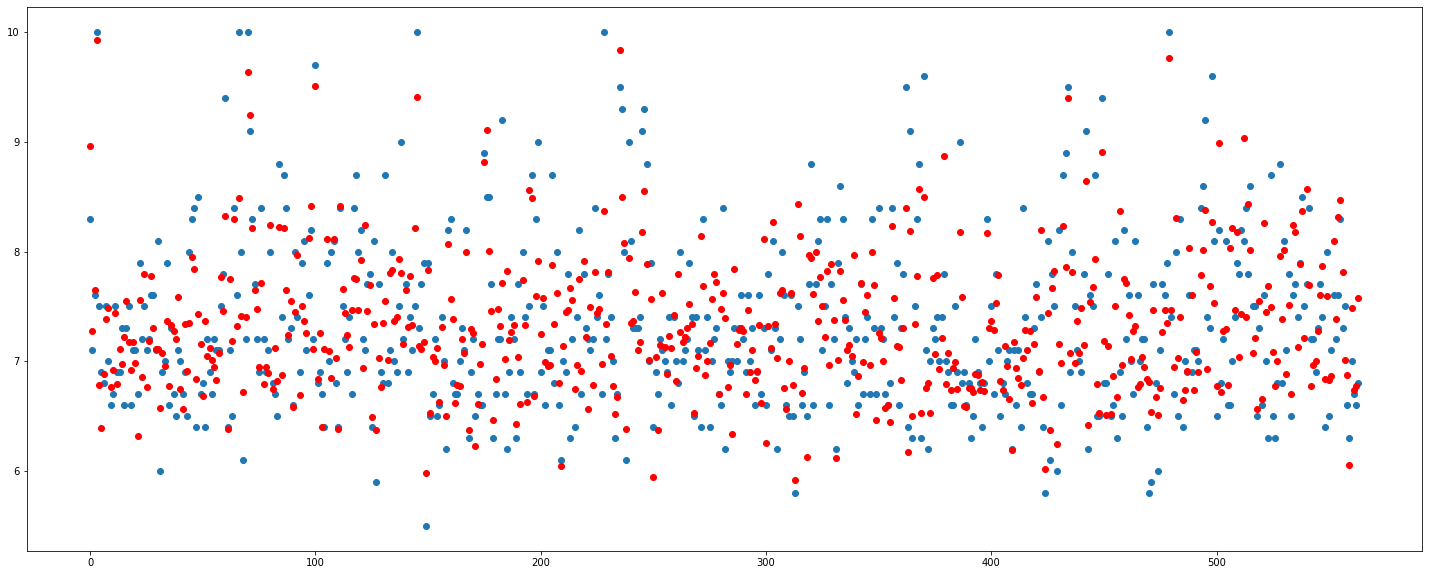

In [11]:
plt.figure(figsize=(25, 10));
plt.scatter(np.array(range(len(y_test_lr))), y_test_lr);
plt.scatter(np.array(range(len(y_pred_lr))), y_pred_lr, c ='r');

In [12]:
# importance = np.abs(linreg_model.coef_)
# plt.figure(figsize=(15, 7));
# plt.bar(height=importance, x=feature_names);
# plt.xticks(rotation = 90);
# plt.title("Feature importances via coefficients on Linear Regression");
# plt.show();
# plt.close();

### Support Vector Regression

In [13]:
svr_model = SVR()
grid = dict()
grid['C'] = [0.5, 0.7, 1]
grid['epsilon'] = [7e-2, 1e-1, 1.0]
grid['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
search = GridSearchCV(svr_model, grid, cv=5, n_jobs=-1)
start = time.time()
search.fit(x_train, y_train)
# grid_svr_elapsedTime = time.time()-start
# print("Tuning time: %.5f seconds" % grid_svr_elapsedTime)
# print(search.best_params_)

svr_model = SVR(kernel=search.best_params_['kernel'], C=search.best_params_['C'], 
            epsilon=search.best_params_['epsilon']).fit(x_train, y_train)
y_pred = svr_model.predict(x_test)
if scaling_output==1:
    y_test_svr = sc_y.inverse_transform(y_test)
    y_pred_svr = sc_y.inverse_transform(y_pred.reshape(-1, 1))
else:
    y_test_svr = y_test
    y_pred_svr = y_pred

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.5, 0.7, 1], 'epsilon': [0.07, 0.1, 1.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [14]:
# Calculating R2 score, rmse and mae
svr_r2_before, svr_mse_before, svr_rmse_before, svr_mae_before = get_metrics(y_test_svr, y_pred_svr)
print_metrics(svr_r2_before, svr_mse_before, svr_rmse_before, svr_mae_before)

R2 score: 0.60277
MSE: 0.24920
RMSE: 0.49920
MAE: 0.38319


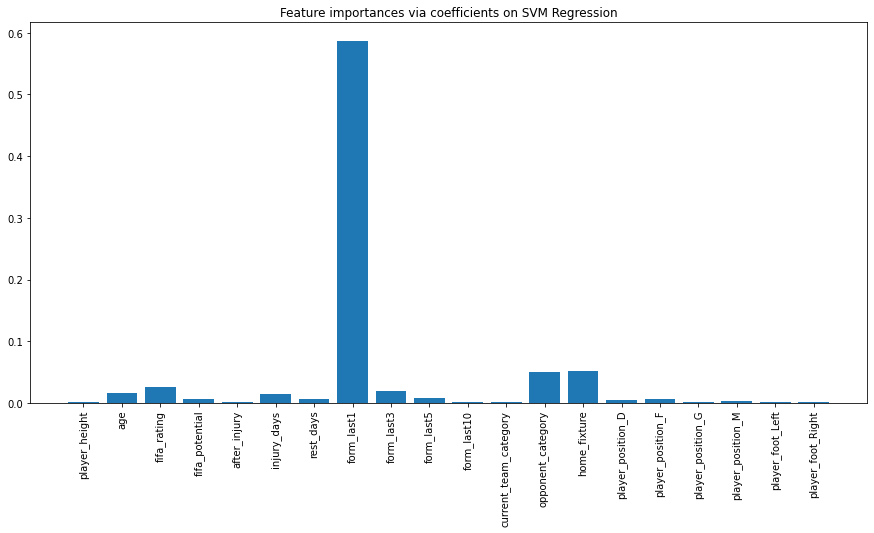

In [15]:
importance = np.abs(svr_model.coef_).flatten()
plt.figure(figsize=(15, 7));
plt.bar(height=importance, x=feature_names);
plt.xticks(rotation = 90);
plt.title("Feature importances via coefficients on SVM Regression");
plt.show();

### Random Forest

In [16]:
rf_model = RandomForestRegressor()
grid = dict()
grid['max_features'] = ['auto', 'sqrt', 'log2']
grid['min_samples_leaf'] = [1, 8, 15]
grid['min_samples_split'] = [2, 8, 14]
grid['n_estimators'] = [60, 80, 100, 120]
search = GridSearchCV(rf_model, grid, cv=5, n_jobs=-1)
start = time.time()
search.fit(x_train, y_train)
# grid_rf_elapsedTime = time.time()-start
# print("Tuning time: %.5f seconds" % grid_rf_elapsedTime)
# print(search.best_params_)

rf_model = RandomForestRegressor(max_features=search.best_params_['max_features'], min_samples_leaf=search.best_params_['min_samples_leaf'], 
            min_samples_split=search.best_params_['min_samples_split'],n_estimators=search.best_params_['n_estimators']).fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
if scaling_output==1:
    y_test_rf = sc_y.inverse_transform(y_test)
    y_pred_rf = sc_y.inverse_transform(y_pred.reshape(-1, 1))
else:
    y_test_rf = y_test
    y_pred_rf = y_pred

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 8, 15],
                         'min_samples_split': [2, 8, 14],
                         'n_estimators': [60, 80, 100, 120]})

In [17]:
# Calculating R2 score, rmse and mae
rf_r2_before, rf_mse_before, rf_rmse_before, rf_mae_before = get_metrics(y_test_rf, y_pred_rf)
print_metrics(rf_r2_before, rf_mse_before, rf_rmse_before, rf_mae_before)

R2 score: 0.58955
MSE: 0.25750
RMSE: 0.50744
MAE: 0.39233


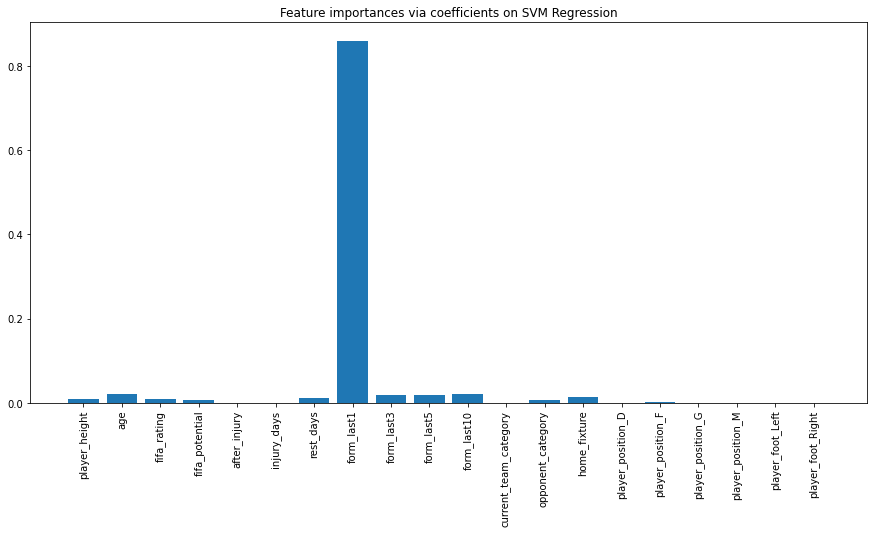

In [19]:
importance = np.abs(rf_model.feature_importances_).flatten()
plt.figure(figsize=(15, 7));
plt.bar(height=importance, x=feature_names);
plt.xticks(rotation = 90);
plt.title("Feature importances via coefficients on SVM Regression");
plt.show();

### XGB Regression

In [20]:
xgb_model = xgboost.XGBRegressor()
grid = {"subsample":[0.5, 1],
        "colsample_bytree":[0.5, 1],
        "max_depth":[5, 6, 7, 8],
        "min_child_weight":[1,5],
        "learning_rate":[0.3, 0.09, 0.03]}
search = GridSearchCV(xgb_model, grid, cv=5, n_jobs=-1)
start = time.time()
search.fit(x_train, y_train)
# grid_xgb_elapsedTime = time.time()-start
# print("Tuning time: %.5f seconds" % grid_xgb_elapsedTime)
# print(search.best_params_)

xgb_model = xgboost.XGBRegressor(subsample=search.best_params_['subsample'], colsample_bytree=search.best_params_['colsample_bytree'], 
        max_depth=search.best_params_['max_depth'], min_child_weight=search.best_params_['min_child_weight'],
        learning_rate=search.best_params_['learning_rate']).fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)

if scaling_output==1:
    y_test_xgb = sc_y.inverse_transform(y_test)
    y_pred_xgb = sc_y.inverse_transform(y_pred.reshape(-1,1))
else:
    y_test_xgb = y_test
    y_pred_xgb = y_pred

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [21]:
# Calculating R2 score, rmse and mae
xgb_r2_before, xgb_mse_before, xgb_rmse_before, xgb_mae_before = get_metrics(y_test_xgb, y_pred_xgb)
print_metrics(xgb_r2_before, xgb_mse_before, xgb_rmse_before, xgb_mae_before)

R2 score: 0.58301
MSE: 0.26160
RMSE: 0.51147
MAE: 0.39259


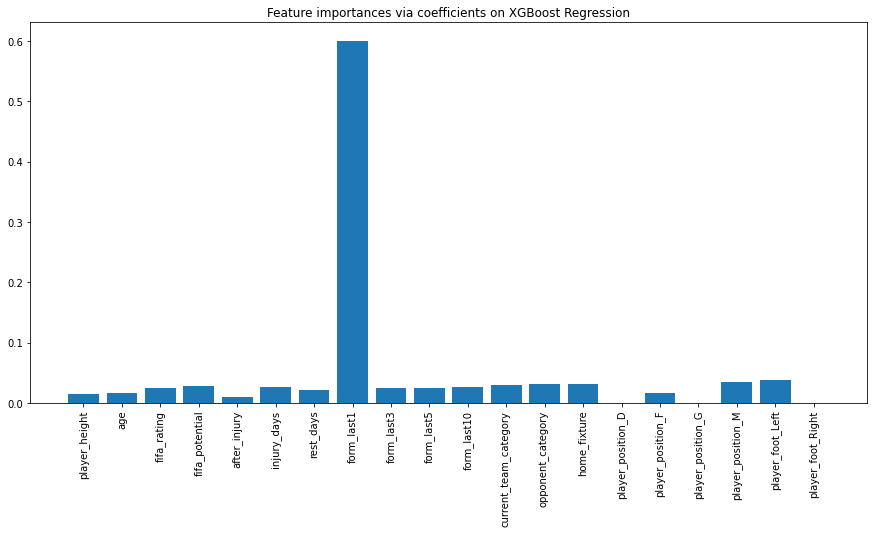

In [22]:
importance = np.abs(xgb_model.feature_importances_)
plt.figure(figsize=(15, 7));
plt.bar(height=importance, x=feature_names);
plt.xticks(rotation = 90);
plt.title("Feature importances via coefficients on XGBoost Regression");
plt.show();

### Multilayer Perceptron Regression

In [ ]:
mlp_model = MLPRegressor(early_stopping=True)
grid = dict()
grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (50,100), (100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.09],
    'learning_rate': ['constant','adaptive'],
}
search = GridSearchCV(mlp_model, grid, cv=5, n_jobs=-1)
start = time.time()
search.fit(x_train, y_train)
# grid_mlp_elapsedTime = time.time()-start
# print("Tuning time: %.5f seconds" % grid_mlp_elapsedTime)
# print(search.best_params_)

mlp_model = MLPRegressor(early_stopping=True, hidden_layer_sizes=search.best_params_['hidden_layer_sizes'], 
        activation=search.best_params_['activation'], solver=search.best_params_['solver'],
        alpha=search.best_params_['alpha'],learning_rate=search.best_params_['learning_rate']).fit(x_train, y_train)
y_pred =mlp_model.predict(x_test)
if scaling_output==1:
    y_test_mlp = sc_y.inverse_transform(y_test)
    y_pred_mlp = sc_y.inverse_transform(y_pred.reshape(-1, 1))
else:
    y_test_mlp = y_test
    y_pred_mlp = y_pred

/home/egkiastas/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
# Calculating R2 score, rmse and mae
mlp_r2_before, mlp_mse_before, mlp_rmse_before, mlp_mae_before = get_metrics(y_test_mlp, y_pred_mlp)
# mlp_r2_before, mlp_mse_before, mlp_rmse_before, mlp_mae_before = get_metrics(y_test_inversed, y_pred_inversed)
print_metrics(mlp_r2_before, mlp_mse_before, mlp_rmse_before, mlp_mae_before)

R2 score: 0.58013
MSE: 0.26341
RMSE: 0.51324
MAE: 0.39642
